In [1]:
import pandas as pd
import biolearn
from biolearn.data_library import DataLibrary
data='../data/'
cache=biolearn.cache.LocalFolderCache(data+'cache',1000)
n=6
def csv2pkl(): #convert csv to pickles (very time consuming so pikcked data provided for reproducing)
    df=pd.read_csv(data+'mesa/dna/dna.csv',nrows=10**n,index_col=0)
    df=df[[c for c in df.columns if 'BIS' in c]]
    df.columns=df.columns.str.split('-').str[0]
    df.to_pickle(data+'mesa/dna/dna.pkl')
    df=pd.read_csv(data+'ppmi/dna/dna.csv',index_col=0,nrows=10**n)
    df.to_pickle(data+'ppmi/dna.pkl')
    df=pd.read_csv(cache_path+'GSE132203_Geo_Submission_GTPEpic.csv',nrows=10**n,usecols=[0]+list(range(1,1591,2)),index_col=0).round(3)
    df.to_pickle(data+'dna/grady.pkl')
    df=pd.read_csv(data+'mgb/dna.csv',nrows=10**n,index_col=0)
    df.columns=df.columns.str.split('-').str[0]
    df.to_pickle(data+'mgb/dna.pkl')

In [2]:
#load cohorts and clean DANm data 
dts=[]
elovs=[]

In [3]:
##mesa
meta=pd.read_table(data+'input/cohorts/mesa/phs001416.v3.pht010510.v1.p1.c1.TOPMed_MESA_Methylomics_Sample_Attributes.HMB.txt',skiprows=10,index_col=0,
                   usecols=['SAMPLE_ID','ASSAY_TYPE','HISTOLOGICAL_TYPE','ANALYTE_ISOLATION_LAB','TOPMED_PHASE','SUBJECT_ID','COLLECTION_VISIT','AGE_AT_COLLECTION'])
meta.shape
meta=meta[(meta['ASSAY_TYPE']=='BIS')&(meta['HISTOLOGICAL_TYPE']=='PBMC')&(meta['ANALYTE_ISOLATION_LAB']=='Tracy-UVT')&(meta['TOPMED_PHASE']=='TOPMed MULTI-OMICS Pilot')].copy()
meta=meta[['COLLECTION_VISIT','AGE_AT_COLLECTION','SUBJECT_ID']]
meta.columns=['visit','age','sid']
meta['visit']=meta['visit'].replace({5:2})
subj=pd.read_table(data+'input/cohorts/mesa/phs000209.v13.pht001116.v10.p3.c1.MESA_Exam1Main.HMB.txt',skiprows=10,index_col=0,usecols=['sidno','gender1'])
subj.columns=['sex']
meta=meta.merge(subj[['sex']],left_on='sid',right_index=True,how='inner')
meta.to_csv(data+'clean/cohorts/meta/mesa_dna.csv')
meta.shape

(1774, 4)

In [4]:
%%time
df=pd.read_pickle(data+'clean/cohorts/dna/mesa.pkl')
df.shape

CPU times: user 187 ms, sys: 15.6 s, total: 15.7 s
Wall time: 43.4 s


(866553, 1955)

In [5]:
%%time
dt=df.T
dt=dt.join(meta[meta['visit']==1][['age']],how='inner')
dt['cohort']='MESA1'
elovs.append(dt[['cg16867657','age','cohort']])
dt=df.T
dt=dt.join(meta[meta['visit']==2][['age']],how='inner')
dt=dt[~dt.index.duplicated(keep='first')].copy()
dt['cohort']='MESA2'
elovs.append(dt[['cg16867657','age','cohort']])
meta=meta[['visit','age','sex']].copy()
meta.columns=['cohort','age','sex']
meta['cohort']=meta.cohort.replace({1:'MESA1',2:'MESA2'})
dts.append(meta[['cohort','sex','age']])
dt.shape

CPU times: user 17 s, sys: 21.6 s, total: 38.6 s
Wall time: 38.7 s


(888, 866555)

In [6]:
%%time
##PPMI
ids=pd.read_table(data+'input/cohorts/ppmi/PPMI_Meth_n524_for_LONI030718.txt',index_col=0)
ids['id']=ids['Sentrix ID'].astype(str)+'_'+ids['Sentrix Position']
meta=pd.read_excel(data+'input/cohorts/ppmi/PPMI_Curated_Data_Cut_Public_20240129.xlsx',sheet_name='20240129')
meta=meta[meta['EVENT_ID']=='BL']
meta.index=meta['PATNO'].astype(str)
meta=meta[['age_at_visit','SEX']].join(ids['id']).dropna() #0:female
meta.columns=['age','sex','id']
meta.index=meta['id']
df=pd.read_pickle(data+'clean/cohorts/dna/ppmi.pkl')
dt=df.T
dt=dt.join(meta.drop('id',axis=1),how='inner')
dt['cohort']='PPMI'
dts.append(dt[['cohort','sex','age']])
elovs.append(dt[['cg16867657','age','cohort']])
dt.shape

CPU times: user 11.1 s, sys: 10.2 s, total: 21.3 s
Wall time: 28.6 s


(510, 865921)

In [7]:
%%time 
##grady
meta=pd.read_table(data+'input/cohorts/grady/GSE132203_series_matrix.txt',skiprows=29,index_col=0).iloc[8:10].T
meta.columns=['sex','age']
meta['age']=meta['age'].str.strip('age: ').astype(float)
meta['sex']=meta['sex'].replace({'gender: Female':0,'gender: Male':1})
df=pd.read_pickle(data+'clean/cohorts/dna/grady.pkl')
dt=df.T
dt=dt.join(meta,how='inner')

<timed exec>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


CPU times: user 2.79 s, sys: 11.8 s, total: 14.6 s
Wall time: 23.5 s


In [8]:
dt['cohort']='Grady'
dts.append(dt[['cohort','sex','age']])
elovs.append(dt[['cg16867657','age','cohort']])

In [9]:
%%time
##mgb
meta=pd.read_csv(data+'clean/cohorts/meta/mgb.csv',index_col=0,usecols=['ID','sex','age_at_sample','race'])
meta.columns=['sex','age','race']
df=pd.read_pickle(data+'clean/cohorts/dna/mgb.pkl')
dt=df.T
dt=dt.join(meta,how='inner')
dt['cohort']='MGB'
dt['sex']=dt['sex'].replace({'F':0,'M':1})
dts.append(dt[['cohort','sex','age','race']])
elovs.append(dt[['cg16867657','age','cohort']])

CPU times: user 2.5 s, sys: 6.54 s, total: 9.04 s
Wall time: 14.7 s


<timed exec>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`


In [10]:
%%time
#load data from GEO usign Biolearn
geos={}
for geo in ['GSE157131','GSE42861']: #geno
    print (geo)
    data_source = DataLibrary(cache=cache).get(geo)
    geos[geo]=data_source.load()

GSE157131
GSE42861
CPU times: user 11.7 s, sys: 5.05 s, total: 16.8 s
Wall time: 16.8 s


In [11]:
##geno
geo='GSE157131'
df=geos[geo].dnam
meta=geos[geo].metadata
meta['sex']=meta['sex']-1
dt=meta[['sex','age']].join(df.T)
dt['cohort']='GENOA'
dts.append(dt[['cohort','sex','age']])
elovs.append(dt[['cg16867657','age','cohort']])

In [12]:
%%time
## RA
geo='GSE42861'
df=geos[geo].dnam
meta=geos[geo].metadata
meta['sex']=meta['sex']-1
dt=meta[['sex','age']].join(df.T)
dt['cohort']='RA'
dts.append(dt[['cohort','sex','age']])
elovs.append(dt[['cg16867657','age','cohort']])

CPU times: user 2.14 s, sys: 2.13 s, total: 4.27 s
Wall time: 4.28 s


In [13]:
ages=pd.concat(dts)
ages['sex']=ages['sex'].replace({0:'Female',1:'Male',2:'Unknown'})
ages.to_csv(data+'result/dna_age.csv')
ages['cohort'].value_counts()

cohort
GENOA    946
MESA2    888
MESA1    886
Grady    795
RA       689
PPMI     510
MGB      461
Name: count, dtype: int64

<Axes: xlabel='cohort', ylabel='age'>

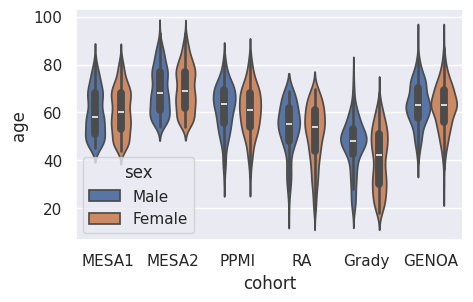

In [14]:
import seaborn as sns 
sns.set(rc={'figure.figsize':(5,3)})
sns.violinplot(data=ages,x='cohort',y='age',hue='sex',order=['MESA1','MESA2','PPMI','RA','Grady','GENOA'])

<Axes: xlabel='age', ylabel='Count'>

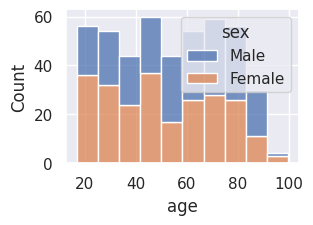

In [15]:
mgb=ages[ages['cohort']=='MGB']
sns.set(rc={'figure.figsize':(3,2)})
sns.histplot(data=mgb, stat="count", x='age', multiple="stack",hue='sex')

<Axes: xlabel='age', ylabel='Count'>

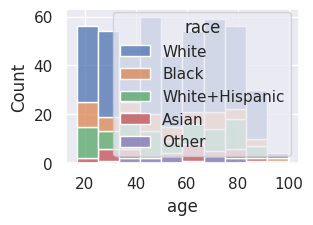

In [16]:
sns.set(rc={'figure.figsize':(3,2)})
sns.histplot(data=mgb, stat="count", x='age', multiple="stack",hue='race')

In [17]:
elov=pd.concat(elovs)
elov.round(3).to_csv(data+'result/elov.csv')
elov['cohort'].value_counts()

cohort
GENOA    946
MESA2    888
MESA1    886
Grady    795
RA       689
PPMI     510
MGB      461
Name: count, dtype: int64

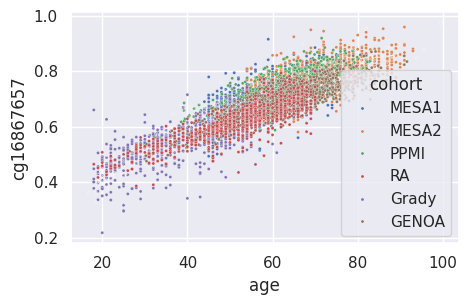

In [18]:
sns.set(rc={'figure.figsize':(5,3)})
sns.scatterplot(data=elov,x='age',y='cg16867657',hue='cohort',hue_order=['MESA1','MESA2','PPMI','RA','Grady','GENOA'],s=5);